In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from astropy.io import fits
from astropy import units as u
from astropy import constants as c

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

I have attached the current output of the nGIST run we did for the current version of the data products. The spatial binning map provide you - for every spaxel - the number of voronoi bin they belong to. The sfh weights includes two extension the "GRID" one includes the grid in age and metallicity used for the fit and the "WEIGHTS" one includes the weights associated to all the models for each of the bins. Your task is to use these info to construct a map of M/L for IC3392.

In [2]:
# # Load IC3392 raw data
# # --------- file location (edit if needed) ----------
# cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
# print("Loading:", cube_path.resolve())

# with fits.open(cube_path) as hdul:
#     # Check the file structure
#     print(hdul.info())
#     data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
#     stat = hdul["STAT"].data.astype(np.float32)
#     dq   = hdul["DQ"].data.astype(np.uint8)
#     hdr  = hdul["DATA"].header
#     hdul.close()

# nz, ny, nx = data.shape
# print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
# hdr


In [3]:
# Load spatial binning map IC3392_individual.fits 
# --------- file location (edit if needed) ----------
binning_path = Path("IC3392_SPATIAL_BINNING_maps.fits")
print("Loading:", binning_path.resolve())
with fits.open(binning_path) as hdul:
    # check data structure and header
    print(hdul.info())
    binning_primary = hdul[0]
    binning_BINID   = hdul[1].data
    binning_FLUX    = hdul[2].data
    binning_SNR     = hdul[3].data
    binning_SNRBIN  = hdul[4].data
    binning_XBIN    = hdul[5].data
    binning_YBIN    = hdul[6].data
    binning_hdr     = hdul[1].header
    hdul.close()

binning_hdr


Loading: /Users/maclaptop29/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps.fits
Filename: IC3392_SPATIAL_BINNING_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
None


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [4]:
np.nanmin(binning_BINID), np.nanmax(binning_BINID),

(np.float64(0.0), np.float64(4076.0))

In [5]:
np.nanmin(binning_XBIN), np.nanmax(binning_XBIN),

(np.float64(-31.299767981438762), np.float64(34.50190476190504))

In [6]:
# Load SFH and weights data IC3392_sfh-weights.fits
# --------- file location (edit if needed) ----------
sfh_path = Path("IC3392_sfh-weights.fits")
print("Loading:", sfh_path.resolve())
with fits.open(sfh_path) as hdul:
    # check data structure and header
    print(hdul.info())
    weights_data = hdul[1].data
    grid_data = hdul[2].data
    weights_hdr  = hdul[1].header
    grid_hdr  = hdul[2].header

    hdul.close()
# weights_hdr
grid_hdr

Loading: /Users/maclaptop29/Desktop/ICRAR/data/IC3392/IC3392_sfh-weights.fits
Filename: IC3392_sfh-weights.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  WEIGHTS       1 BinTableHDU     27   4077R x 1C   [477D]   
  2  GRID          1 BinTableHDU     31   477R x 3C   [D, D, D]   
None


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                  477 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'LOGAGE  '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'METAL   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'ALPHA   '        

In [7]:
weights_hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3816 / length of dimension 1                          
NAXIS2  =                 4077 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'WEIGHTS '                                                            
TFORM1  = '477D    '                                                            
EXTNAME = 'WEIGHTS '           / extension name                                 
METHOD  = 'ppxf    '                                                            
LMIN    =                 48

In [8]:
weights_data.shape

(4077,)

In [9]:
len(weights_data[1][0])

477

In [10]:
grid_data

FITS_rec([(-1.52287875, -1.49, 0.), (-1.52287875, -1.26, 0.),
          (-1.52287875, -0.96, 0.), (-1.52287875, -0.66, 0.),
          (-1.52287875, -0.35, 0.), (-1.52287875, -0.25, 0.),
          (-1.52287875,  0.06, 0.), (-1.52287875,  0.15, 0.),
          (-1.52287875,  0.26, 0.), (-1.39794001, -1.49, 0.),
          (-1.39794001, -1.26, 0.), (-1.39794001, -0.96, 0.),
          (-1.39794001, -0.66, 0.), (-1.39794001, -0.35, 0.),
          (-1.39794001, -0.25, 0.), (-1.39794001,  0.06, 0.),
          (-1.39794001,  0.15, 0.), (-1.39794001,  0.26, 0.),
          (-1.30103   , -1.49, 0.), (-1.30103   , -1.26, 0.),
          (-1.30103   , -0.96, 0.), (-1.30103   , -0.66, 0.),
          (-1.30103   , -0.35, 0.), (-1.30103   , -0.25, 0.),
          (-1.30103   ,  0.06, 0.), (-1.30103   ,  0.15, 0.),
          (-1.30103   ,  0.26, 0.), (-1.22184875, -1.49, 0.),
          (-1.22184875, -1.26, 0.), (-1.22184875, -0.96, 0.),
          (-1.22184875, -0.66, 0.), (-1.22184875, -0.35, 0.),
        

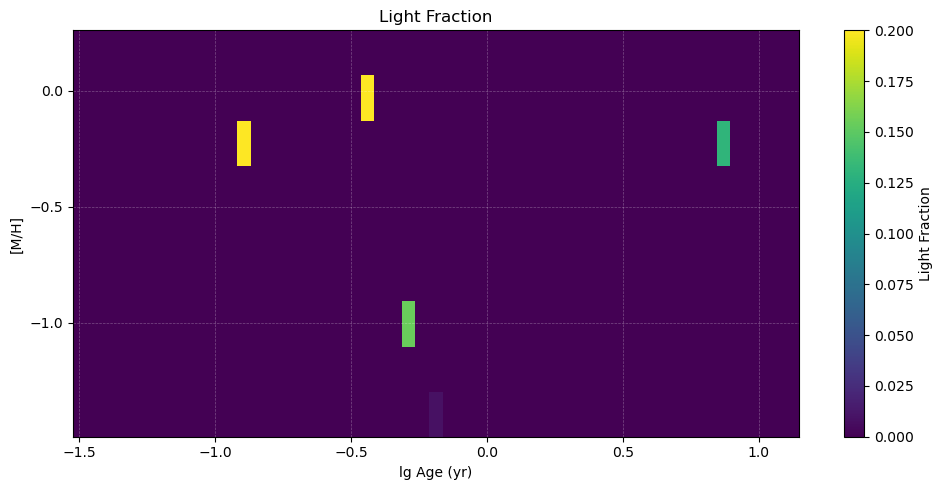

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# weights_data is your numpy array of shape (477,)
# grid_data is your FITS_rec array with LOGAGE, METAL, ALPHA values

# Extract unique log ages and metallicities from grid_data
log_ages = np.unique(grid_data['LOGAGE'])
metallicities = np.unique(grid_data['METAL'])

# Create a 2D grid to store the light fraction values
light_fraction = np.zeros((len(metallicities), len(log_ages)))

# Create a dictionary mapping (LOGAGE, METAL) tuples to indices in the grid_data
grid_indices = {(row['LOGAGE'], row['METAL']): i for i, row in enumerate(grid_data)}

# Fill the grid with light fraction values
for log_age_idx, log_age in enumerate(log_ages):
    for metal_idx, metal in enumerate(metallicities):
        key = (log_age, metal)
        if key in grid_indices:
            idx = grid_indices[key]
            if idx < len(weights_data[0][0]):  # Ensure index is within bounds
                light_fraction[metal_idx, log_age_idx] = weights_data[4076][0][idx]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Determine extent based on the data ranges
x_min, x_max = min(log_ages), max(log_ages)
y_min, y_max = min(metallicities), max(metallicities)

# Plot the heatmap
im = ax.imshow(light_fraction, origin='lower', aspect='auto',
              extent=[x_min, x_max, y_min, y_max],
              vmin=0, vmax=0.2)

# Set axis labels and title
ax.set_xlabel('lg Age (yr)')
ax.set_ylabel('[M/H]')
ax.set_title('Light Fraction')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Light Fraction')

# Set axis ticks
x_ticks = np.arange(np.floor(x_min * 2) / 2, np.ceil(x_max * 2) / 2 + 0.1, 0.5)
ax.set_xticks(x_ticks)
ax.set_yticks([-1.5, -1.0, -0.5, 0.0])

# Add grid
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)

ax.set_xlim(np.min(log_ages), np.max(log_ages))
ax.set_ylim(np.min(metallicities), np.max(metallicities))

plt.tight_layout()
# plt.savefig('light_fraction_heatmap.png', dpi=300)
plt.show()

In [12]:
log_ages.shape, metallicities.shape

((53,), (9,))

In [13]:
weights_hdr['LMIN'], weights_hdr['LMAX']

(4800, 7000)

In [14]:
10**log_ages

array([ 0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.15,
        0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.6 ,  0.7 ,
        0.8 ,  0.9 ,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,
        2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.5 ,  5.  ,  5.5 ,
        6.  ,  6.5 ,  7.  ,  7.5 ,  8.  ,  8.5 ,  9.  ,  9.5 , 10.  ,
       10.5 , 11.  , 11.5 , 12.  , 12.5 , 13.  , 13.5 , 14.  ])

In [15]:
import numpy as np
from pathlib import Path

# ---------- 2.1  Column names (from HEADER_out_phot) ----------
names = [
    'IMF','slope','MH','Age','U','B','V','R','I','J','H','K',
    'UminusV','BminusV','VminusR','VminusI','VminusJ','VminusH','VminusK',
    'ML_U','ML_B','ML_V','ML_R','ML_I','ML_J','ML_H','ML_K',
    'F439W','F555W','F675W','F814W','C439_555','C555_675','C555_814'
]

fname = Path("BaSTI+Chabrier.dat")

# ---------- 2.2  Load data, skip the two header lines ----------
tbl = np.genfromtxt(
    fname, dtype=None, encoding=None, names=names,
    comments='#', skip_header=2, autostrip=True
)                                  # :contentReference[oaicite:2]{index=2}

# ---------- 2.3  Keep only Chabrier rows ----------
mask = (tbl['IMF'] == 'Ch')
phot = tbl[mask]


In [16]:
# --- 3.1  Build a lookup dict keyed by (logAge, MH) rounded to 2 dec —--
key_ml = {}

for row in phot:
    age_gyr = round(row['Age'], 2)                     # e.g. 0.03 → 0.03
    mh_dex  = round(row['MH'],  2)                     # e.g. –2.27 → –2.27
    mlr     = row['ML_R']                   # keep 2 dp as requested
    key_ml[(age_gyr, mh_dex)] = mlr


In [17]:

grid = grid_data  # the FITS_rec you already loaded

# --- 4.1  Prepare new array with an extra ML_R column -------------
mlr_values = np.full(len(grid), np.nan, dtype=np.float32)

for i, (logage, mh, _) in enumerate(grid):
    age_gyr = round(10**logage, 2)   # yrs → Gyr, 2 dp
    mh_dex  = round(mh, 2)                 # already dex
    mlr_values[i] = key_ml.get((age_gyr, mh_dex), np.nan)

# --- 4.2  Build a new structured array including ML_R -------------
ml_dtype = grid.dtype.descr + [('ML_R', 'f4')]
grid_mlr  = np.empty(len(grid), dtype=ml_dtype)

for name in grid.dtype.names:
    grid_mlr[name] = grid[name]
grid_mlr['ML_R'] = mlr_values


In [18]:
key_ml

{(np.float64(0.03), np.float64(-2.27)): np.float64(0.129),
 (np.float64(0.04), np.float64(-2.27)): np.float64(0.144),
 (np.float64(0.05), np.float64(-2.27)): np.float64(0.157),
 (np.float64(0.06), np.float64(-2.27)): np.float64(0.165),
 (np.float64(0.07), np.float64(-2.27)): np.float64(0.172),
 (np.float64(0.08), np.float64(-2.27)): np.float64(0.163),
 (np.float64(0.09), np.float64(-2.27)): np.float64(0.151),
 (np.float64(0.1), np.float64(-2.27)): np.float64(0.12),
 (np.float64(0.15), np.float64(-2.27)): np.float64(0.147),
 (np.float64(0.2), np.float64(-2.27)): np.float64(0.162),
 (np.float64(0.25), np.float64(-2.27)): np.float64(0.176),
 (np.float64(0.3), np.float64(-2.27)): np.float64(0.192),
 (np.float64(0.35), np.float64(-2.27)): np.float64(0.203),
 (np.float64(0.4), np.float64(-2.27)): np.float64(0.215),
 (np.float64(0.45), np.float64(-2.27)): np.float64(0.229),
 (np.float64(0.5), np.float64(-2.27)): np.float64(0.238),
 (np.float64(0.6), np.float64(-2.27)): np.float64(0.26),
 (np.

In [19]:
grid_mlr

array([(-1.52287875, -1.49, 0., 0.082), (-1.52287875, -1.26, 0., 0.07 ),
       (-1.52287875, -0.96, 0., 0.057), (-1.52287875, -0.66, 0., 0.057),
       (-1.52287875, -0.35, 0., 0.062), (-1.52287875, -0.25, 0., 0.062),
       (-1.52287875,  0.06, 0., 0.064), (-1.52287875,  0.15, 0., 0.065),
       (-1.52287875,  0.26, 0., 0.069), (-1.39794001, -1.49, 0., 0.092),
       (-1.39794001, -1.26, 0., 0.08 ), (-1.39794001, -0.96, 0., 0.068),
       (-1.39794001, -0.66, 0., 0.07 ), (-1.39794001, -0.35, 0., 0.073),
       (-1.39794001, -0.25, 0., 0.076), (-1.39794001,  0.06, 0., 0.078),
       (-1.39794001,  0.15, 0., 0.081), (-1.39794001,  0.26, 0., 0.087),
       (-1.30103   , -1.49, 0., 0.102), (-1.30103   , -1.26, 0., 0.091),
       (-1.30103   , -0.96, 0., 0.079), (-1.30103   , -0.66, 0., 0.082),
       (-1.30103   , -0.35, 0., 0.086), (-1.30103   , -0.25, 0., 0.088),
       (-1.30103   ,  0.06, 0., 0.093), (-1.30103   ,  0.15, 0., 0.097),
       (-1.30103   ,  0.26, 0., 0.102), (-1.2218487

In [20]:
weights_data

FITS_rec([([0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.  

In [21]:
weights_data['WEIGHTS'].astype(np.float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4077, 477), dtype=float32)

In [22]:
grid_mlr['ML_R'].astype(np.float32)

array([0.082, 0.07 , 0.057, 0.057, 0.062, 0.062, 0.064, 0.065, 0.069,
       0.092, 0.08 , 0.068, 0.07 , 0.073, 0.076, 0.078, 0.081, 0.087,
       0.102, 0.091, 0.079, 0.082, 0.086, 0.088, 0.093, 0.097, 0.102,
       0.111, 0.099, 0.089, 0.092, 0.095, 0.096, 0.103, 0.107, 0.114,
       0.117, 0.106, 0.098, 0.102, 0.105, 0.108, 0.115, 0.121, 0.127,
       0.117, 0.108, 0.103, 0.109, 0.113, 0.115, 0.125, 0.13 , 0.136,
       0.115, 0.11 , 0.109, 0.117, 0.121, 0.123, 0.134, 0.139, 0.145,
       0.114, 0.112, 0.117, 0.126, 0.131, 0.134, 0.145, 0.15 , 0.155,
       0.133, 0.133, 0.14 , 0.152, 0.16 , 0.166, 0.184, 0.189, 0.194,
       0.153, 0.155, 0.157, 0.173, 0.19 , 0.193, 0.216, 0.221, 0.227,
       0.169, 0.172, 0.176, 0.193, 0.215, 0.219, 0.243, 0.249, 0.255,
       0.19 , 0.192, 0.199, 0.214, 0.24 , 0.246, 0.269, 0.275, 0.282,
       0.205, 0.209, 0.221, 0.241, 0.266, 0.272, 0.295, 0.301, 0.308,
       0.22 , 0.224, 0.236, 0.26 , 0.289, 0.298, 0.32 , 0.327, 0.336,
       0.235, 0.24 ,

In [23]:
# --- prerequisites already in memory ---------------------------------------
# weights_data['WEIGHTS']   -> (4077, 477)   light fractions per bin
# grid_mlr['ML_R']          -> (477,)        R-band M/L per template

# 1) convert the opaque FITS_rec into a plain ndarray
w      = weights_data['WEIGHTS'].astype(np.float32)        # (4077, 477)
ml_ssp = grid_mlr['ML_R'].astype(np.float32)               # (477,)

# 2) light-weighted M/L_R per Voronoi bin (shape 4077)
ml_bin = (w * ml_ssp).sum(axis=1)     # or: np.dot(w, ml_ssp)

# 3) optional sanity check: every bin should return a finite, positive value
assert np.all(np.isfinite(ml_bin)) and (ml_bin > 0).all()


In [24]:
ml_bin

array([1.1946754 , 1.6521219 , 1.7839103 , ..., 1.528122  , 0.71707416,
       0.8589499 ], shape=(4077,), dtype=float32)

In [25]:
binning_BINID

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(438, 437), dtype='>f8')

In [26]:
len(binning_BINID[binning_BINID==4076])

359

In [27]:
# --- 0)  inputs already in memory ------------------------------------------
# binning_BINID  -> (ny, nx) float array   (NaN   = originally masked pixel
#                                            <0    = masked, but *belongs to* |id|)
# ml_bin         -> (N_bin,) float array   (your 4 077 zone M/L_R values)

# --- 1)  create blank map, same shape & dtype ------------------------------
binning_MLR = np.full_like(binning_BINID, np.nan, dtype=np.float32)

# --- 2)  fill *valid* Voronoi zones ----------------------------------------
valid = binning_BINID >= 0                     # True where BINID is a real zone
binning_MLR[valid] = ml_bin[binning_BINID[valid].astype(int)]

binning_MLR


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(438, 437), dtype=float32)

In [28]:
binning_MLR[binning_MLR>0].shape

(73168,)

In [29]:
binning_BINID[binning_BINID>=0].shape

(73168,)

In [30]:
# -------------------------------------------------------------------------
# inputs already in memory:
#   binning_MLR  -> (438, 437) float32   (we’ll cast to float64 like others)
#   binning_path -> Path to original file ("IC3392_SPATIAL_BINNING_maps.fits")
# -------------------------------------------------------------------------

out_path = Path("IC3392_SPATIAL_BINNING_maps_extended.fits")

# 1) read the whole HDUList from disk
with fits.open(binning_path) as hdul:
    # 2) clone all existing HDUs into a new list
    new_hdul = fits.HDUList([hdu.copy() for hdu in hdul])

# 3) build the new ML_R image HDU
ml_hdu = fits.ImageHDU(data=binning_MLR.astype(np.float64), name="ML_R")

# 4) keep WCS and pixel-scale info by copying the original BINID header
ml_hdu.header.update(binning_hdr)         # you created binning_hdr earlier
ml_hdu.header["EXTNAME"] = "ML_R"
ml_hdu.header["BUNIT"]   = "Msol/Lsol_R"  # physical units

# 5) append and write to disk
new_hdul.append(ml_hdu)
new_hdul.writeto(out_path, overwrite=True)

print(f"Saved extended file to {out_path.resolve()}")


Saved extended file to /Users/maclaptop29/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


In [31]:
binning_FLUX

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(438, 437), dtype='>f8')

In [32]:
np.nansum(binning_FLUX*binning_MLR)/np.nansum(binning_FLUX), np.log10(np.nansum(binning_FLUX*binning_MLR)/np.nansum(binning_FLUX))


(np.float64(1.4416080066671668), np.float64(0.1588471857060981))

In [33]:
# -----------------------------------------------------------------
# INPUT ARRAYS (438, 437) :
#   binning_FLUX   erg s^-1 cm^-2 Å^-1  (10^-20 factor still present)
#   binning_MLR    M☉ / L☉_R
# DISTANCE:
D = 11.5 * u.Mpc
lam_r = 6231 * u.AA

# 1) flux density F_λ  →  F_ν
F_lambda = binning_FLUX * 1e-20 * u.erg / u.s / u.cm**2 / u.AA
F_nu     = (F_lambda * lam_r**2 / c.c).to(u.erg / u.s / u.cm**2 / u.Hz)

# 2) apparent AB magnitude per spaxel
F_nu0 = (3631 * u.Jy).to(F_nu.unit)
m_r   = -2.5 * np.log10( (F_nu / F_nu0).value )

# 3) absolute magnitude & solar-unit luminosity
M_r   = m_r - 5*np.log10( (D.to(u.pc).value)/10 )
M_sun = 4.64                       # AB mag of the Sun in r
L_Lsun = 10**(-0.4 * (M_r - M_sun))   # dimensionless L/L☉_r

# 4) stellar mass map & its log10
M_star = L_Lsun * binning_MLR          # M☉ per spaxel
logM_star = np.log10(M_star, where=(M_star>0))  # keep NaN where flux=0

# logM_star now holds log10(M*/M☉) for every valid spaxel


In [34]:
-2.5 * np.log10( np.nansum((F_nu / F_nu0).value) )

np.float64(12.323084524018153)

In [35]:
logM_star.max(), logM_star.min()

(np.float64(5.578155399772873), np.float64(0.0))

In [36]:
np.log10(np.nansum(M_star))

np.float64(9.20700905680606)

In [37]:
np.log10(np.nansum(L_Lsun))

np.float64(9.048161871099962)

In [38]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   binning_hdr    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    mass_hdu = fits.ImageHDU(data=logM_star.astype(np.float64),  # like others
                             header=binning_hdr, name="LOGMSTAR")
    mass_hdu.header["BUNIT"] = "log(Msol)"                   # units keyword
    hdul.append(mass_hdu)                                    # add as 9-th HDU
    hdul.flush()                                             # write in-place

print("Stellar-mass layer saved ➜", out_path.resolve())


Stellar-mass layer saved ➜ /Users/maclaptop29/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


In [39]:
# Setup SPS templates

# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'
# sps_name = 'xsl'

ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

# Inspect the NPZ to see its structure
npz = np.load(filename)
print("Contents:", npz.files)
for key in npz.files:
    arr = npz[key]
    print(f"{key}: shape={arr.shape}, dtype={arr.dtype}")


Contents: ['templates', 'masses', 'lam', 'ages', 'metals', 'fwhm']
templates: shape=(16675, 25, 6), dtype=float64
masses: shape=(25, 6), dtype=float64
lam: shape=(16675,), dtype=float64
ages: shape=(25,), dtype=float64
metals: shape=(6,), dtype=float64
fwhm: shape=(16675,), dtype=float64


In [40]:
npz['metals'], npz['ages'],

(array([-1.71, -1.31, -0.71, -0.4 ,  0.  ,  0.22]),
 array([ 0.0631,  0.0794,  0.1   ,  0.1259,  0.1585,  0.1995,  0.2512,
         0.3162,  0.3981,  0.5012,  0.631 ,  0.7943,  1.    ,  1.2589,
         1.5849,  1.9953,  2.5119,  3.1623,  3.9811,  5.0119,  6.3096,
         7.9433, 10.    , 12.5893, 15.8489]))

In [41]:
np.round((10**npz['metals'])*0.019, 4)

array([0.0004, 0.0009, 0.0037, 0.0076, 0.019 , 0.0315])

In [42]:
metallicities

array([-1.49, -1.26, -0.96, -0.66, -0.35, -0.25,  0.06,  0.15,  0.26],
      dtype='>f8')

In [43]:
np.round((10**metallicities)*0.0198, 4)

array([0.0006, 0.0011, 0.0022, 0.0043, 0.0088, 0.0111, 0.0227, 0.028 ,
       0.036 ])

In [44]:
np.round(np.unique(phot['MH']), 2)

array([-2.27, -1.79, -1.49, -1.26, -0.96, -0.66, -0.35, -0.25,  0.06,
        0.15,  0.26,  0.4 ])

In [45]:
np.round((10**np.unique(phot['MH']))*0.0198, 4)

array([0.0001, 0.0003, 0.0006, 0.0011, 0.0022, 0.0044, 0.0088, 0.0111,
       0.0227, 0.0279, 0.0357, 0.0494])

In [46]:
10**log_ages

array([ 0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.15,
        0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.6 ,  0.7 ,
        0.8 ,  0.9 ,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,
        2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.5 ,  5.  ,  5.5 ,
        6.  ,  6.5 ,  7.  ,  7.5 ,  8.  ,  8.5 ,  9.  ,  9.5 , 10.  ,
       10.5 , 11.  , 11.5 , 12.  , 12.5 , 13.  , 13.5 , 14.  ])